#### https://www.kaggle.com/c/sai-ecg-classification


In [1]:
# Download from Google Drive
!pip install --upgrade gdown
!gdown --id 18OYbRKPSUcapmGzbxmSfVnz7UMz7OGnO

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18OYbRKPSUcapmGzbxmSfVnz7UMz7OGnO
To: /content/ecg-kaggle.zip
100% 2.72M/2.72M [00:00<00:00, 153MB/s]


In [2]:
# unzip dataset
!unzip ecg-kaggle.zip

Archive:  ecg-kaggle.zip
   creating: kaggle/
  inflating: __MACOSX/._kaggle       
  inflating: kaggle/Icon             
  inflating: __MACOSX/kaggle/._Icon  
  inflating: kaggle/test.csv         
  inflating: __MACOSX/kaggle/._test.csv  
  inflating: kaggle/train.csv        
  inflating: __MACOSX/kaggle/._train.csv  


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import os
from tqdm.auto import tqdm

import torch
from torch import nn
import torchsummary

torch.__version__

'2.0.1+cu118'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
MODEL_PATH = 'ecg.pth'

#### Read data and visualize sample

kaggle/

*   train.csv: training data with ground truth
*   test.csv: signal **without** ground truth


---


column 0 ~ 186: signal

column 187: label (5 classes 0~4)


In [6]:
# read data by pandas dataframe
df = pd.read_csv('kaggle/train.csv')
test_df = pd.read_csv('kaggle/test.csv')
num_classes=5

df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.952899,0.952899,0.653986,0.438406,0.409420,0.403986,0.364130,0.309783,0.268116,0.222826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.964968,0.646497,0.773885,0.366242,0.181529,0.162420,0.149682,0.146497,0.146497,0.136943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.977551,1.000000,0.608163,0.393878,0.369388,0.324490,0.275510,0.226531,0.185714,0.144898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.943878,0.905612,0.706633,0.239796,0.063776,0.150510,0.114796,0.043367,0.015306,0.043367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.945338,0.848875,0.508039,0.234727,0.131833,0.125402,0.080386,0.086817,0.070740,0.073955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


idx:  1295
label:  1


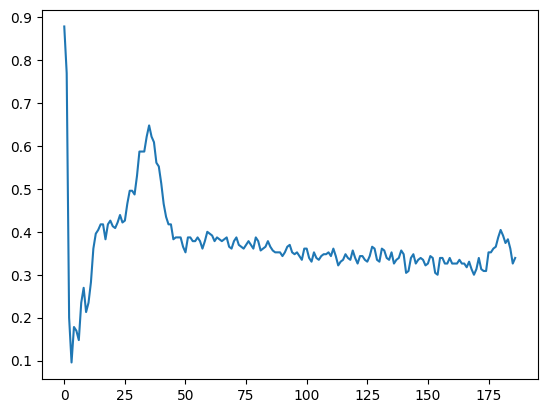

In [27]:
# plot random signal with label
idx = np.random.randint(0, len(df))
signals, label = df.iloc[idx, :-1], df.iloc[idx, -1]

print('idx: ', idx)
print('label: ', int(label))

plt.plot(np.array(signals))
plt.show()

In [28]:
# label distribution
np.unique(df.iloc[:, -1], return_counts=True)

(array([0., 1., 2., 3., 4.]), array([1208,   45,   98,   10,   98]))

#### Dataset & DataLoader

In [29]:
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, df, mode):
        super().__init__()
        self.df = df
        self.mode = mode # train, val, test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        signal = self.df.iloc[idx, :-1] # (187, )
        # convert to tensor, add channel dim
        signal = torch.tensor(signal, dtype=torch.float).unsqueeze(0) # (187, ) -> (1, 187)

        # read label if not test dataset
        if self.mode != 'test':
            label = self.df.iloc[idx, -1]
            label = torch.tensor(label, dtype=torch.long)
            return signal, label
        else:
            return signal

In [30]:
BS = 64

# split to train & val dataset
train_df, val_df = train_test_split(df,
                                    random_state=5566,
                                    test_size=0.2)

train_ds = ECGDataset(train_df, 'train')
val_ds = ECGDataset(val_df, 'val')
test_ds = ECGDataset(test_df, 'test')

train_loader = torch.utils.data.DataLoader(train_ds, BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BS)
test_loader = torch.utils.data.DataLoader(test_ds, BS)

In [31]:
len(train_ds), len(val_ds), len(test_ds)

(1167, 292, 730)

label:  0


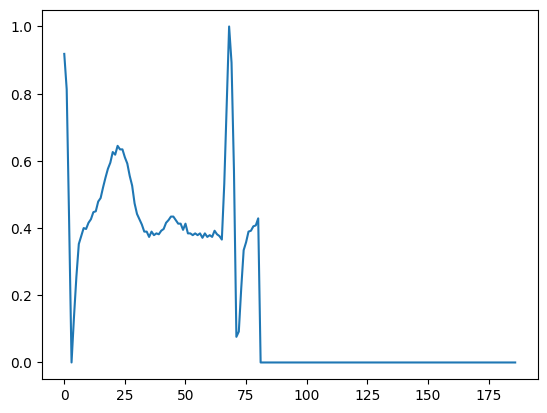

In [32]:
# check data from dataset
signal, label = train_ds[0]
print('label: ', label.item())
plt.plot(signal.squeeze(0)) # remove channel dim
plt.show()

#### Model

2D VGG -> 1D VGG



*   Conv2d
*   BatchNorm2d
*   MaxPool2d
*   AdaptiveAvgPool2d, (output size)
*   in_ch



In [33]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(),
            nn.Conv1d(out_ch, out_ch, kernel_size=3),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
    def forward(self, x):
        return self.block(x)

class VGG(nn.Module):
    def __init__(self, in_ch, num_cls=5):
        super().__init__()
        self.block1 = ConvBlock(in_ch, 64)
        self.block2 = ConvBlock(64, 128)
        self.block3 = ConvBlock(128, 256)
        self.pool = nn.AdaptiveAvgPool1d((1))# nn.AdaptiveAvgPool2d((1,1)), Global Average Pooling
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, num_cls),
        )
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x) # (256, 1)
        x = self.classifier(x) # (256,) -> (num_cls)
        return x

model = VGG(in_ch=1, num_cls=5) # VGG(in_ch=3, num_cls=5)

In [34]:
# torchsummary.summary(model.to(device), (3, 256, 256))
torchsummary.summary(model.to(device), (1, 187), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 185]             256
       BatchNorm1d-2              [-1, 64, 185]             128
              ReLU-3              [-1, 64, 185]               0
            Conv1d-4              [-1, 64, 183]          12,352
       BatchNorm1d-5              [-1, 64, 183]             128
              ReLU-6              [-1, 64, 183]               0
         MaxPool1d-7               [-1, 64, 91]               0
         ConvBlock-8               [-1, 64, 91]               0
            Conv1d-9              [-1, 128, 89]          24,704
      BatchNorm1d-10              [-1, 128, 89]             256
             ReLU-11              [-1, 128, 89]               0
           Conv1d-12              [-1, 128, 87]          49,280
      BatchNorm1d-13              [-1, 128, 87]             256
             ReLU-14              [-1, 

#### Training

In [36]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # Sets the model in training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        optimizer.zero_grad() # set prevision gradient to 0
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        epoch_loss += loss.item()
        epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss/num_batches, epoch_correct/size


def test_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval()
    epoch_loss, epoch_correct = 0, 0
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss/num_batches, epoch_correct/size

In [37]:
def train(epochs, model):

    loss_fn = nn.CrossEntropyLoss() # Softmax + NLLLoss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,
                                 weight_decay=1e-3) # L2 regularization

    logs = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc = test_epoch(val_loader, model, loss_fn)

        print(f'EPOCH: {epoch:04d} \
        train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
        val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)
        # Save model
        torch.save(model.state_dict(), MODEL_PATH)

    # plot result
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(logs['train_loss'])
    plt.plot(logs['val_loss'])
    plt.subplot(1, 2, 2)
    plt.title('Acc.')
    plt.plot(logs['train_acc'])
    plt.plot(logs['val_acc'])
    plt.show()



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0000         train_loss: 0.6765, train_acc: 0.805         val_loss: 0.7888, val_acc: 0.822 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0001         train_loss: 0.4284, train_acc: 0.867         val_loss: 0.6467, val_acc: 0.815 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0002         train_loss: 0.3649, train_acc: 0.893         val_loss: 0.6754, val_acc: 0.849 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0003         train_loss: 0.2994, train_acc: 0.920         val_loss: 0.3026, val_acc: 0.918 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0004         train_loss: 0.2517, train_acc: 0.935         val_loss: 0.2622, val_acc: 0.914 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0005         train_loss: 0.2220, train_acc: 0.934         val_loss: 0.2338, val_acc: 0.942 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0006         train_loss: 0.1976, train_acc: 0.945         val_loss: 0.2427, val_acc: 0.932 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0007         train_loss: 0.1985, train_acc: 0.939         val_loss: 0.2229, val_acc: 0.935 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0008         train_loss: 0.1740, train_acc: 0.953         val_loss: 0.2177, val_acc: 0.942 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0009         train_loss: 0.1723, train_acc: 0.947         val_loss: 0.2730, val_acc: 0.921 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0010         train_loss: 0.1567, train_acc: 0.953         val_loss: 0.2229, val_acc: 0.921 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0011         train_loss: 0.1516, train_acc: 0.949         val_loss: 0.3225, val_acc: 0.925 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0012         train_loss: 0.1476, train_acc: 0.959         val_loss: 0.2570, val_acc: 0.932 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0013         train_loss: 0.1548, train_acc: 0.959         val_loss: 0.3970, val_acc: 0.853 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0014         train_loss: 0.1412, train_acc: 0.955         val_loss: 0.2073, val_acc: 0.955 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0015         train_loss: 0.1123, train_acc: 0.969         val_loss: 0.2510, val_acc: 0.935 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0016         train_loss: 0.1126, train_acc: 0.963         val_loss: 0.1848, val_acc: 0.952 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0017         train_loss: 0.1010, train_acc: 0.966         val_loss: 0.2570, val_acc: 0.925 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0018         train_loss: 0.0937, train_acc: 0.968         val_loss: 0.1854, val_acc: 0.945 


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0019         train_loss: 0.0747, train_acc: 0.981         val_loss: 0.1862, val_acc: 0.955 


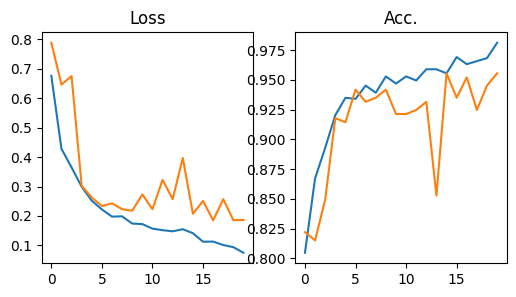

In [38]:
# Model
model = VGG(1, num_cls=5)
model = model.to(device)
train(epochs=20, model=model)

#### Metrics

In [39]:
model = VGG(1, num_cls=5).to(device)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [40]:
model.eval()
# Predic by model
y_pred = []
y_true = []
with torch.no_grad():
    for data in val_loader:
        signal, label = data
        signal, label = signal.to(device), label.to(device)

        pred = model(signal).argmax(dim=-1).cpu()
        y_pred.append(pred)
        y_true.append(label.cpu())

y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

y_pred.shape, y_true.shape

(torch.Size([292]), torch.Size([292]))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       240
           1       1.00      0.33      0.50         9
           2       0.94      0.89      0.92        19
           3       0.00      0.00      0.00         1
           4       1.00      0.87      0.93        23

    accuracy                           0.96       292
   macro avg       0.78      0.62      0.66       292
weighted avg       0.95      0.96      0.95       292

[[239   0   1   0   0]
 [  6   3   0   0   0]
 [  2   0  17   0   0]
 [  1   0   0   0   0]
 [  3   0   0   0  20]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


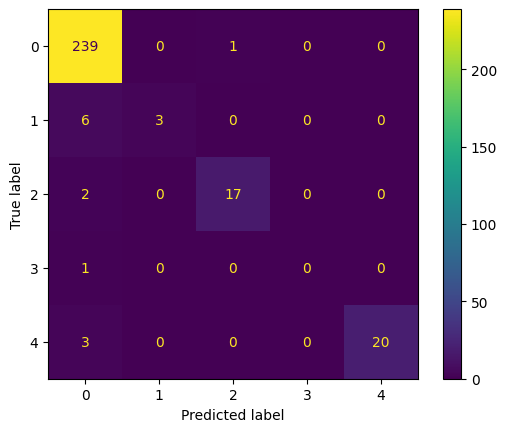

In [41]:
# Classification report & confussion matrics
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred) # confusion matrix
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[str(i) for i in range(num_classes)])
disp.plot()

#### Make Kaggle prediction file

https://www.kaggle.com/c/sai-ecg-classification

In [ ]:
model.eval()
# Predict by model
predictions = []

for signal in test_loader:
    signal = signal.to(device)
    with torch.no_grad():
        pred = model(signal).argmax(dim=-1).cpu()
        predictions.append(pred)
predictions = torch.cat(predictions)

df_submit = pd.DataFrame([], columns=['Id', 'Category'])
df_submit['Id'] = [f'{i:03d}' for i in range(len(predictions))]
df_submit['Category'] = predictions

df_submit.to_csv('submission.csv', index=None)

#### TODO:



*   build your own 1D model
*   find a 1D model



#### FusionLab

https://github.com/taipingeric/fusionlab

In [ ]:
!pip install fusionlab

In [43]:
import fusionlab as fl

PyTorch installed: True
TensorFlow installed: True


In [ ]:
encoder = fl.encoders.ResNet18(cin=1, spatial_dims=1)
encoder

In [ ]:
model = nn.Sequential(
    encoder,
    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Linear(512, 5),
)
model

In [ ]:
torchsummary.summary(model.to(device), (1, 187), device=device)